<a href="https://colab.research.google.com/github/pyagoubi/Stuff/blob/main/stock_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


torch.Size([7684, 1])
Epoch 1/1000, Train Loss: 0.3281, Validation Loss: 0.0361
torch.Size([7684, 1])
Epoch 2/1000, Train Loss: 0.2241, Validation Loss: 0.0347
torch.Size([7684, 1])
Epoch 3/1000, Train Loss: 0.1292, Validation Loss: 0.2915
torch.Size([7684, 1])
Epoch 4/1000, Train Loss: 0.2326, Validation Loss: 0.1297
torch.Size([7684, 1])
Epoch 5/1000, Train Loss: 0.1330, Validation Loss: 0.0424
torch.Size([7684, 1])
Epoch 6/1000, Train Loss: 0.1116, Validation Loss: 0.0239
torch.Size([7684, 1])
Epoch 7/1000, Train Loss: 0.1281, Validation Loss: 0.0209
torch.Size([7684, 1])
Epoch 8/1000, Train Loss: 0.1341, Validation Loss: 0.0197
torch.Size([7684, 1])
Epoch 9/1000, Train Loss: 0.1241, Validation Loss: 0.0193
torch.Size([7684, 1])
Epoch 10/1000, Train Loss: 0.1016, Validation Loss: 0.0235
torch.Size([7684, 1])
Epoch 11/1000, Train Loss: 0.0745, Validation Loss: 0.0390
torch.Size([7684, 1])
Epoch 12/1000, Train Loss: 0.0569, Validation Loss: 0.0638
torch.Size([7684, 1])
Epoch 13/1000, 

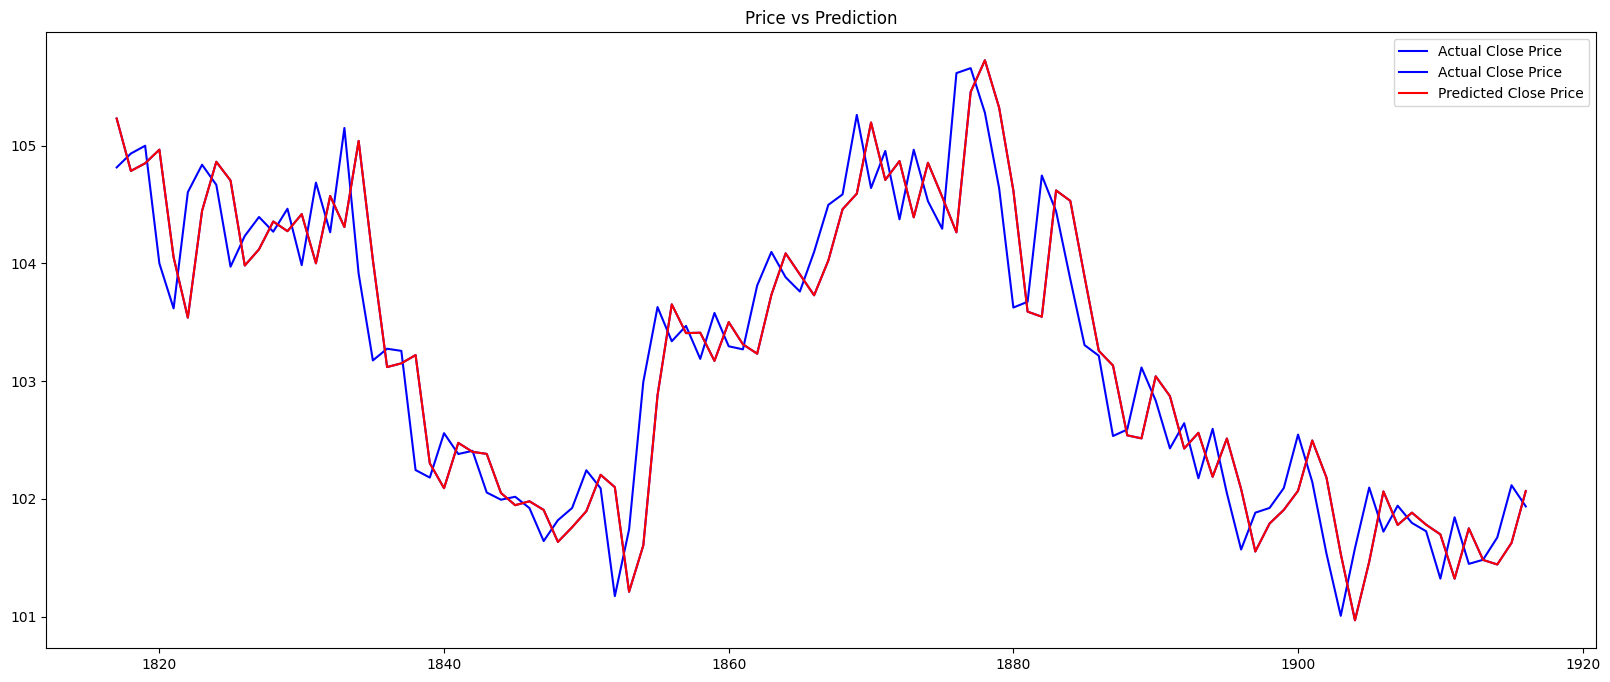

In [4]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
#import bt as bt
import os, sys, itertools, urllib, io
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset

# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

split_fraction = 0.8
time_steps = 5 # number of predictor timesteps
horizon = 1 # number of timesteps to be predicted
sequence_length = time_steps + horizon # determine sequence length
learning_rate=0.01
num_epochs=1000


data_raw = pd.read_csv('/content/drive/MyDrive/stock predict/technical/1D_technical.csv')
#features = ['open', 'high', 'low', 'close', 'rsi', 'adx', 'cci', 'ema', 'stoch', 'trend_macd', 'momentum_stoch', 'volatility_atr']
cols = ['time','close']
features = ['close']
input_size = len(features)
data = data_raw[features].copy()

#data = data[['close']].copy()

split_row = int(data.shape[0] * split_fraction)

train_data = data.iloc[:split_row].copy()
valid_data = data.iloc[split_row:].copy()

f_scaler = MinMaxScaler(feature_range=(-1, 1))
t_scaler = MinMaxScaler(feature_range=(-1, 1))

if input_size == 2:
  train_data.loc[:, train_data.columns != 'close'] = f_scaler.fit_transform(train_data.loc[:, train_data.columns != 'close'].values.reshape(-1,1))
  valid_data.loc[:, valid_data.columns != 'close'] = f_scaler.transform(valid_data.loc[:, valid_data.columns != 'close'].values.reshape(-1,1))
elif input_size >2:
  train_data.loc[:, train_data.columns != 'close'] = f_scaler.fit_transform(train_data.loc[:, train_data.columns != 'close'])
  valid_data.loc[:, valid_data.columns != 'close'] = f_scaler.fit_transform(valid_data.loc[:, valid_data.columns != 'close'])

train_data['close'] = t_scaler.fit_transform(train_data['close'].values.reshape(-1,1))
valid_data['close'] = t_scaler.transform(valid_data['close'].values.reshape(-1,1))

def create_sequences(df, seq_length):
    df = df.values  # Convert DataFrame to numpy array
    
    n = df.shape[0]
    xs = np.zeros((n - seq_length, seq_length, df.shape[1]))
    ys = np.zeros((n - seq_length, 1))
    
    for i in range(n - seq_length):
        xs[i] = df[i:(i+seq_length)]
        ys[i] = df[i+seq_length, -1]  # predict the 'return' column one step ahead
    
    # Convert to PyTorch tensors
    X = torch.from_numpy(xs)
    y = torch.from_numpy(ys)
    
    return X, y
train_data, train_target = create_sequences(train_data, sequence_length)
valid_data, valid_target = create_sequences(valid_data, sequence_length)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):

      super(LSTM, self).__init__()
      
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)    
      self.fc1 = nn.Linear(hidden_size, 10)
      self.fc2 = nn.Linear(10, output_size)  # Add a second layer

      self.tanh = nn.Tanh()

    def forward(self, x):

      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 

      h0.requires_grad = True
      c0.requires_grad = True

      out, _ = self.lstm(x, (h0.detach(), c0.detach()))
      out = self.tanh(self.fc1(out[:, -1, :]))  # apply tanh activation function to the output of the first linear layer
      out = self.fc2(out)  # pass through the second linear layer
    

      # out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
      # out = self.fc1(out[:, -1, :])
      # out = self.tanh(out) 
   
      return out

def train(model, train, train_target, valid, valid_target, learning_rate, num_epochs):

  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []

  train = train.float().to(device)  # Convert to float
  train_target = train_target.float().to(device)  # Convert to float
  valid = valid.float().to(device)  # Convert to float
  valid_target = valid_target.float().to(device)  # Convert to float

  best_loss = float('inf')

  for epoch in range(num_epochs):

    model.train()
    y_train_pred = model(train)

    print(y_train_pred.shape)
    train_loss = criterion(y_train_pred, train_target)
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

    model.eval()
    outputs = model(valid)
    val_loss = criterion(outputs, valid_target)

    print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss.item():.4f}, '
              f'Validation Loss: {val_loss.item():.4f}')
    
    if val_loss < best_loss:
      best_loss = val_loss
      torch.save(model, '/content/drive/MyDrive/stock predict/prediction_model.pt')

num_features = train_data.shape[-1]  # X is your input data
model = LSTM(input_size=input_size, hidden_size=50, num_layers=2, output_size=1)
model = model.to(device)
train(model, train_data, train_target, valid_data, valid_target, learning_rate, num_epochs=num_epochs)


#load best model
model = torch.load('/content/drive/MyDrive/stock predict/prediction_model.pt')
model = model.to(device)
model.eval()
valid_data = valid_data.float().to(device) # Convert to float
val_pred = model(valid_data)

actuals = pd.DataFrame(t_scaler.inverse_transform(valid_target.detach().cpu().numpy()))
preds = pd.DataFrame(t_scaler.inverse_transform(val_pred.detach().cpu().numpy()))

valid = pd.DataFrame(columns = ['actuals', 'predictions'])
valid['actuals'] = actuals
valid['predictions'] = preds
plt.figure(figsize=(20,8))
plt.title('Price vs Prediction')
plt.plot(valid[len(valid)-100:], color = 'blue', label = 'Actual Close Price')
plt.plot(valid[len(valid)-100:]['predictions'], color = 'red', label = 'Predicted Close Price')
plt.legend()
plt.show()



In [13]:
valid['predictions'].shift(-1).values

array([ 98.467804,  97.4654  ,  97.815605, ..., 101.62528 , 102.06569 ,
              nan], dtype=float32)

In [47]:
bt_df = data_raw[split_row+sequence_length:]
bt_df = bt_df[['time','open','high','low', 'close']].copy()
bt_df['predictions'] = valid['predictions'].shift(-1).values
bt_df['signal'] = 0
bt_df.loc[bt_df['predictions']>bt_df['close'], 'signal' ] =1
bt_df.loc[bt_df['predictions']<bt_df['close'], 'signal' ] =-1
bt_df = bt_df.rename(columns=lambda x: x.capitalize())
bt_df = bt_df[:-1].copy()
bt_df

,Time,Open,High,Low,Close,Predictions,Signal
7696,2015-12-08 00:00:00+00:00,98.730,98.763,98.332,98.404,98.467804,1
7697,2015-12-09 00:00:00+00:00,98.442,98.521,97.223,97.391,97.465401,1
7698,2015-12-10 00:00:00+00:00,97.409,97.988,97.360,97.931,97.815605,-1
7699,2015-12-11 00:00:00+00:00,97.975,98.095,97.329,97.631,97.661194,1
7700,2015-12-13 22:00:00+00:00,97.621,97.932,97.275,97.583,97.581871,-1
...,...,...,...,...,...,...,...
9607,2023-04-24 23:00:00+00:00,101.257,101.949,101.199,101.843,101.748619,-1
9608,2023-04-25 23:00:00+00:00,101.815,101.891,101.013,101.447,101.480507,1
9609,2023-04-26 23:00:00+00:00,101.396,101.802,101.283,101.482,101.441948,-1
9610,2023-04-27 23:00:00+00:00,101.473,102.172,101.423,101.672,101.625282,-1


In [26]:
%%capture
!pip install backtesting

import backtesting as bt
from backtesting import Backtest, Strategy

In [48]:
bt_df['Time'] = pd.to_datetime(bt_df['Time'])

# Now, set 'time' as index
bt_df = bt_df.set_index('Time')

In [56]:
class SignalStrategy(Strategy):
    def init(self):
        self.signal = self.data['Signal']
        display(self.data)  # Print DataFrame

    def next(self):
        #print(f"Signal on date {self.data.index[-1]}: {self.signal[-1]}")  # Print signal
        if self.signal[-1] == 1:
            if not self.position or self.position.is_short:
                #print(f"Buying on date {self.data.index[-1]}")
                self.position.close()
                self.buy()

        elif self.signal[-1] == -1:
            if not self.position or self.position.is_long:
                #print(f"Selling on date {self.data.index[-1]}")
                self.position.close()
                self.sell()

# Create a backtest and run it
btest = Backtest(bt_df[1800:], SignalStrategy, cash=10000, commission=.002)
stats = btest.run()

print(stats)

<Data i=115 (2023-04-30 21:00:00+00:00) Open=101.672, High=102.189, Low=101.624, Close=102.115, Predictions=102.06568908691406, Signal=-1.0, Volume=nan>

Start                     2022-11-15 00:00...
End                       2023-04-30 21:00...
Duration                    166 days 21:00:00
Exposure Time [%]                   98.275862
Equity Final [$]                 10411.951804
Equity Peak [$]                  10474.555804
Return [%]                           4.119518
Buy & Hold Return [%]                -4.18125
Return (Ann.) [%]                   13.544425
Volatility (Ann.) [%]               10.401315
Sharpe Ratio                         1.302184
Sortino Ratio                        2.220442
Calmar Ratio                         3.360867
Max. Drawdown [%]                   -4.030039
Avg. Drawdown [%]                   -1.113573
Max. Drawdown Duration       71 days 00:00:00
Avg. Drawdown Duration       17 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       4.132279
Worst Trade [%]                      4.132279
Avg. Trade [%]                    

In [57]:
btest.plot()

<ipython-input-57-e9d5fa14abab>:1: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  btest.plot()


Row(id='3365', ...)

In [58]:
bt_df[1800:]

,Open,High,Low,Close,Predictions,Signal
2022-11-15 00:00:00+00:00,106.997,107.104,105.340,106.571,106.568939,-1
2022-11-16 00:00:00+00:00,106.581,106.784,105.859,106.285,106.277054,-1
2022-11-17 00:00:00+00:00,106.267,107.240,106.098,106.691,106.606842,-1
2022-11-18 00:00:00+00:00,106.693,107.043,106.337,106.969,106.947754,-1
2022-11-20 22:00:00+00:00,106.969,107.993,106.894,107.775,107.728554,-1
...,...,...,...,...,...,...
2023-04-24 23:00:00+00:00,101.257,101.949,101.199,101.843,101.748619,-1
2023-04-25 23:00:00+00:00,101.815,101.891,101.013,101.447,101.480507,1
2023-04-26 23:00:00+00:00,101.396,101.802,101.283,101.482,101.441948,-1
2023-04-27 23:00:00+00:00,101.473,102.172,101.423,101.672,101.625282,-1
